# Homework 4: Regression with Gaussian Processes

------------------------------------------------------
*Machine Learning, Master in Information Health Engineering, 2019-2020*

Authors:


*   Ignacio Serrano
*   Leandro Hidalgo


*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

The aim of this homework is to solve a real data problem using the Gaussian Process implementation of GPy. The documentation of GPy is avaialable from the [SheffieldML github page](https://github.com/SheffieldML/GPy) or from [this page](http://gpy.readthedocs.org/en/latest/). 

The problem is the prediction of both the heating load (HL) and cooling load (CL) of residential buildings. We consider eight input variables for each building: relative compactness, surface area, wall area, roof area, overall height, orientation, glazing area, glazing area distribution.

In this [paper](https://www.sciencedirect.com/science/article/pii/S037877881200151X) you can find a detailed description of the problem and a solution based on linear regression [(iteratively reweighted least squares (IRLS) algorithm)](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=10&ved=2ahUKEwjZuoLY2OjgAhUs3uAKHUZ7BVcQFjAJegQIAhAC&url=https%3A%2F%2Fpdfs.semanticscholar.org%2F9b92%2F18e7233f4d0b491e1582c893c9a099470a73.pdf&usg=AOvVaw3YDwqZh1xyF626VqfnCM2k) and random forests. Using GPs, our goal is not only estimate accurately both HL and CL, but also get a measure of uncertainty in our predictions.

The data set can be downloaded from the [UCI repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency#).

## 1. Loading and preparing the data

* Download the dataset
* Divide at random the dataset into train (80%) and test (20%) datasets 
* Normalize data if needed

In [0]:
from google.colab import files
data = files.upload()

Saving ENB2012_data.xlsx to ENB2012_data (1).xlsx


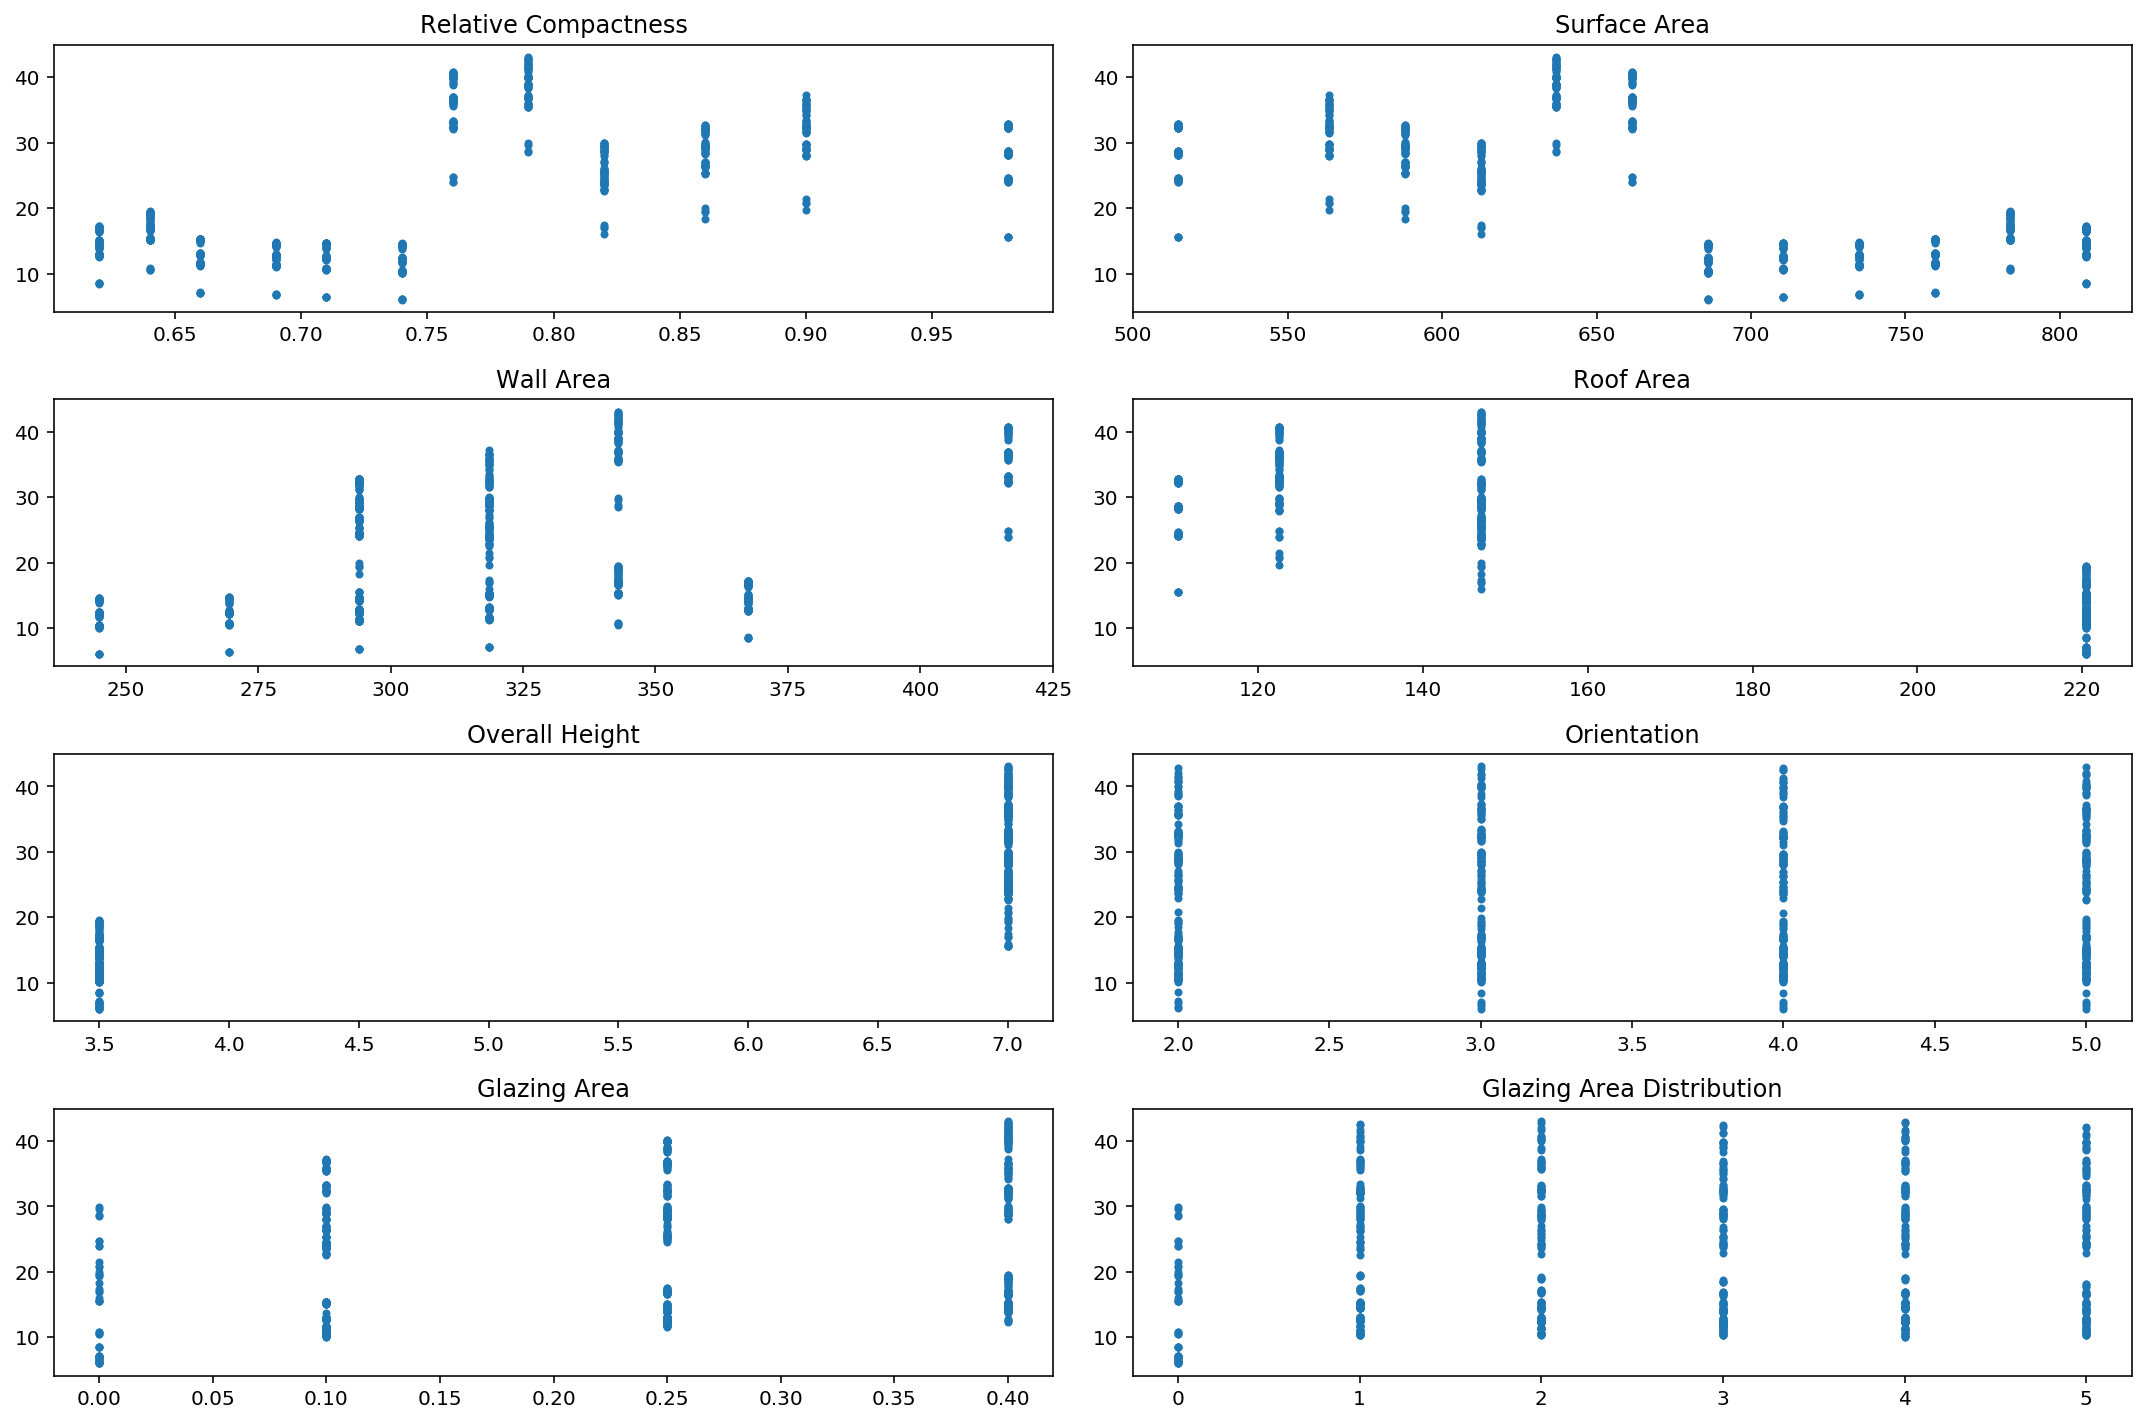

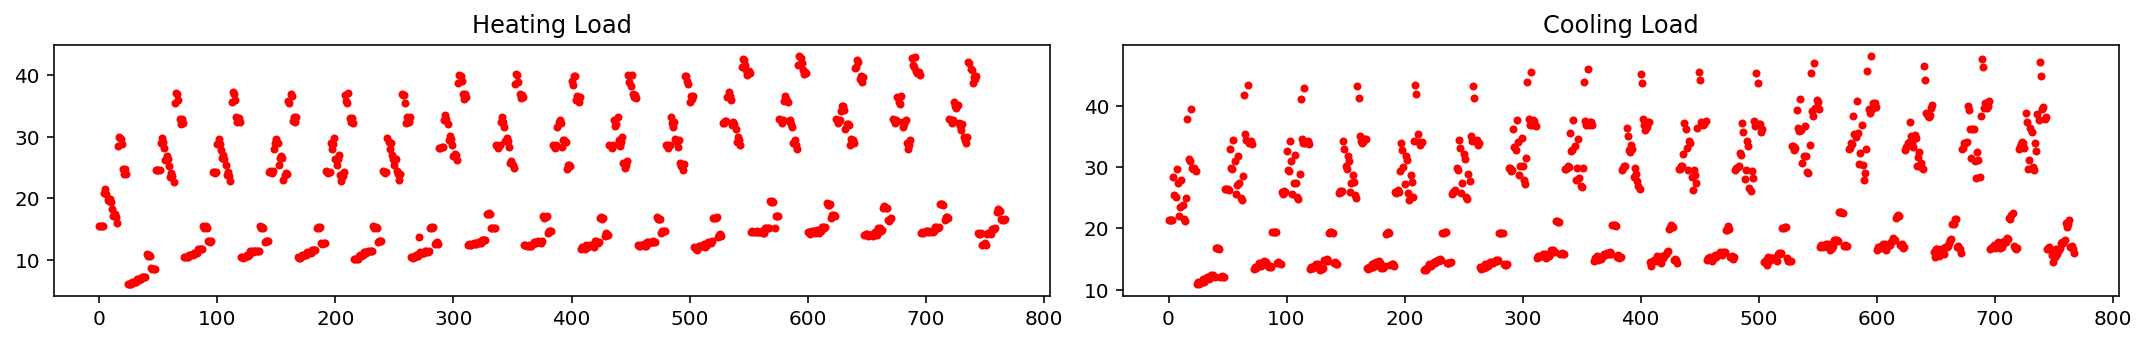

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

names=['Relative Compactness','Surface Area','Wall Area','Roof Area','Overall Height','Orientation','Glazing Area','Glazing Area Distribution','Heating Load','Cooling Load']

data = pd.read_excel('ENB2012_data.xlsx', sep='\t', names=names)

X_ex=data.iloc[:,:8]
Y_ex=data.iloc[:,8:]

X=np.array(X_ex)
Y=np.array(Y_ex)

# Generate train and test partitions
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Data normalization (µ = 0, σ = 1)
transformer = StandardScaler().fit(X_train)
X_train= transformer.transform(X_train)
X_test=  transformer.transform(X_test)

Xrange = X.shape[1]
Yrange = Y.shape[1]

plt.figure( figsize=(15,10))
for d in range (Xrange):
  plt.subplot(4,2,d+1)
  plt.plot(X[:,d],Y[:,0],'.',)
  plt.title(names[d])
  plt.tight_layout()

plt.figure( figsize=(15,2.5))
for d in range (Yrange):
  plt.subplot(1,2,d+1)
  plt.plot(Y[:,d],'.r')
  plt.title(names[Xrange+d])
  plt.tight_layout()


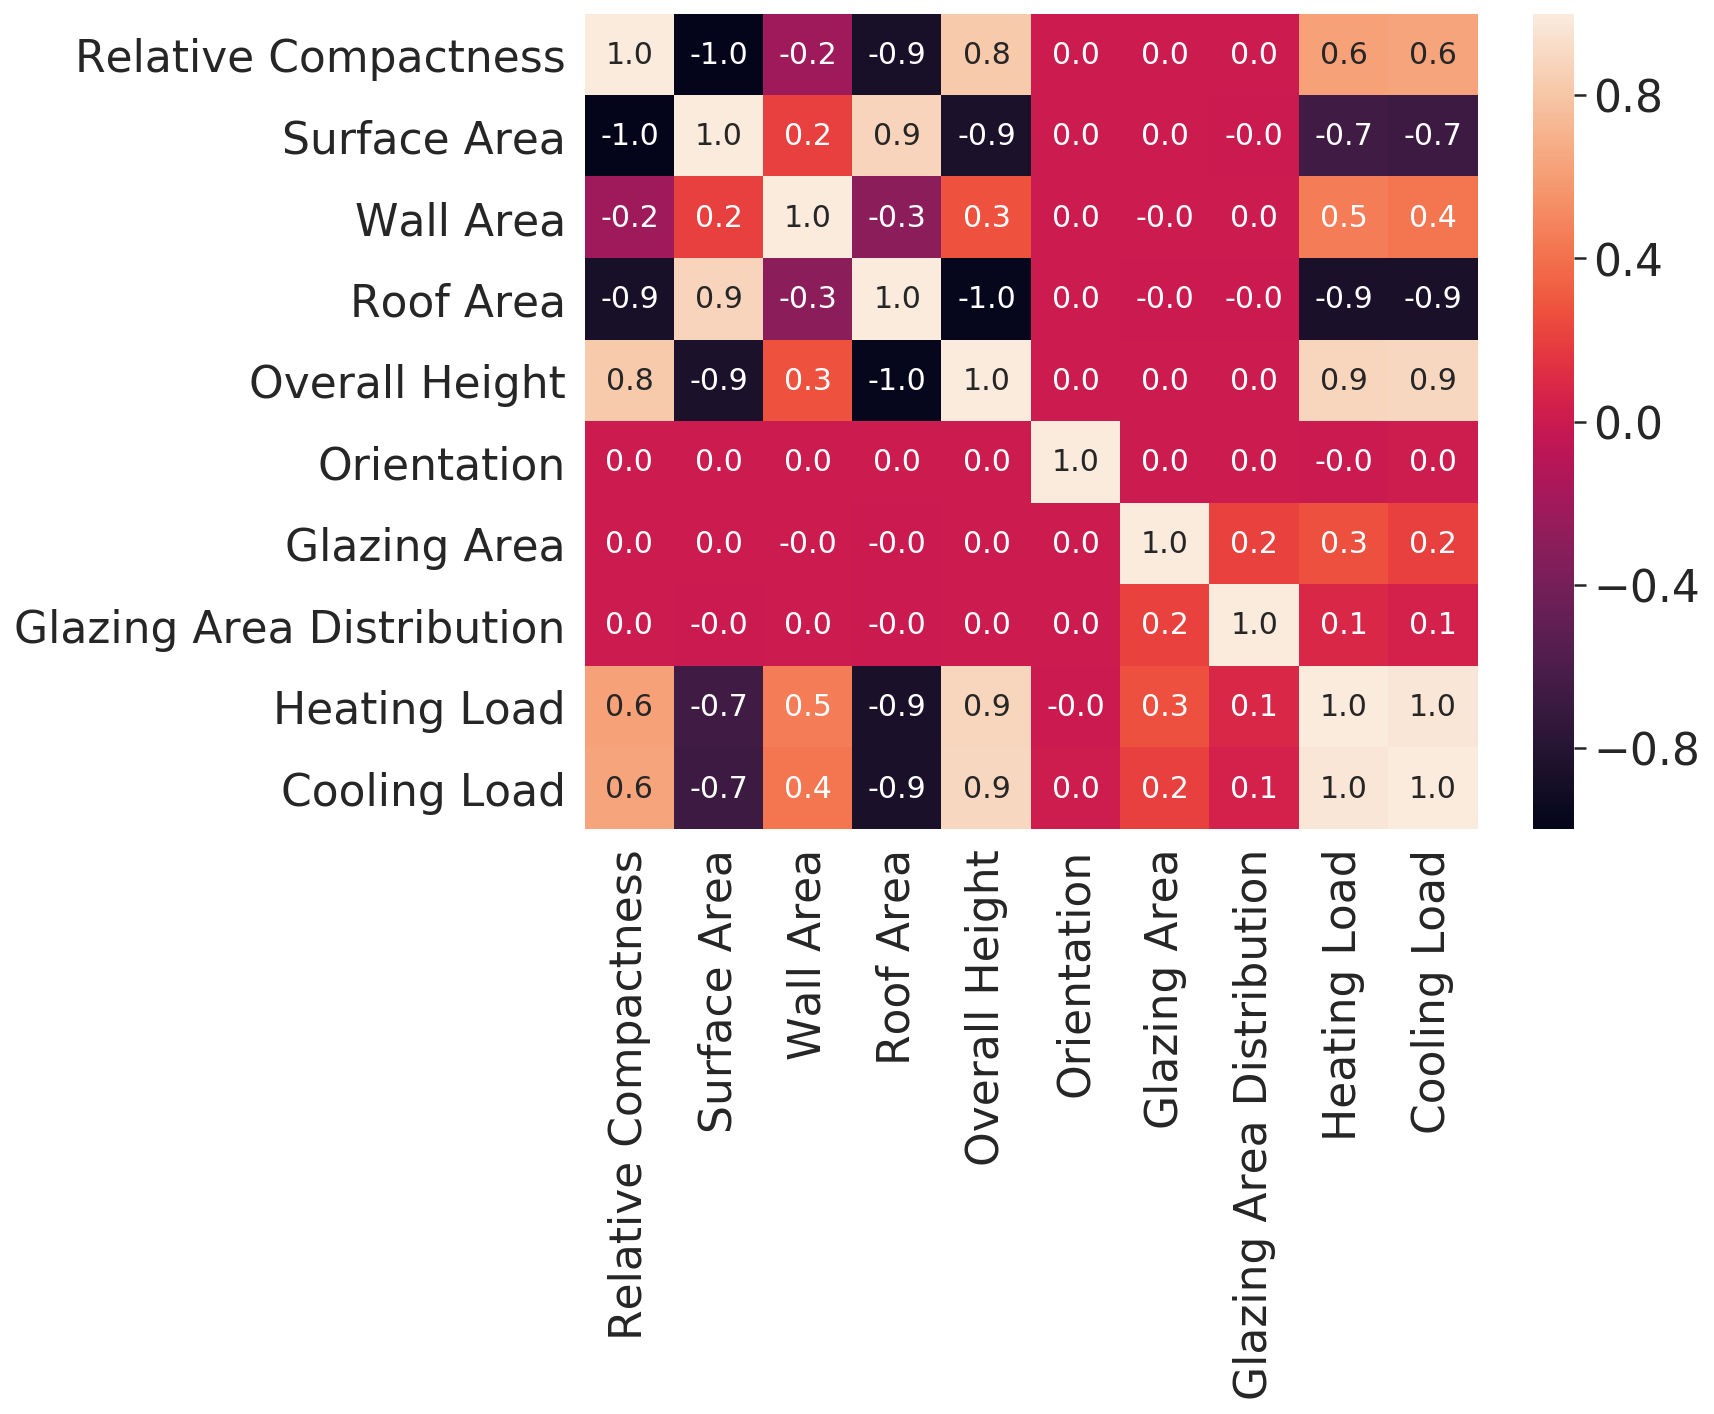

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'   ##QUALITY FIGURES!!
plt.rcParams["figure.figsize"] = [8,8]

#CORRELATION MATRIX
corr=data.corr()
plt.figure(figsize=(10,7.5))
sns.set(font_scale=2)
sns.heatmap(corr,vmin=-1,vmax=1,cbar=True,annot=True,square=False,fmt='.1f',
                 annot_kws={'size': 15}, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

### EXPLANATION

*In this part, we've uploaded the data and, after the normalization, we've build some graphs  in order to see how the distribution of the data is so we can have an idea of it.*

*Although this won't solve anything, it might be helpful for us to understand whether a solution seem to be correct or not.*


## 2. Setting and optimizing the model

You will train two independent GPs, one to estimate HL and one to estimate CL. For each of the two GPs ...

**On the training data set:**

a) Build a GP regression model based on a RBF kernel with ARD, in which each input dimension is weighted with a different lengthscale, plus some constant noise term. 

b) Fit the covariance function parameters and noise variance. 

c) According to the ARD parameters found, what variables are more important for the regression? Compare it to Table 8 in the [paper](https://www.sciencedirect.com/science/article/pii/S037877881200151X) 

**On the test data set:**

d) Compute the test mean absolute error error and the test mean square error (MSE)  using the GP posterior mean and the optimized hyperparameters. Compare your results with Tables 6 and 7 in the [paper](https://www.sciencedirect.com/science/article/pii/S037877881200151X).


2) Try to improve your results by using a more complicated kernel, in which you combine various covariance functions. In this [link](http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_kernels.ipynb) you can see how to define different kernels and combine  them. Comments the results. 



In [0]:
!pip install GPy 

     |████████████████████████████████| 1.0MB 9.9MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2634005 sha256=4f153fb468c984d46c8a0d78e3a603717592be67cae6fdcbaeea088afc4be7d0
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102551 sha256=bc9203f0fb5b8827fe629a1bbd367596f18df6a9576488af5f3ecf9e10c1d6a7
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [0]:
import GPy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [0]:
#Let's divide the labels in the two differents ones that we want to estimate.

Y_train_HL = Y_train[:,:1]
Y_train_CL = Y_train[:,1:]

Y_test_HL = Y_test[:,:1]
Y_test_CL = Y_test[:,1:]

### Heating Load Estimation

**a) Build a GP regression model**

In [0]:
# define kernel
RBF_kernel_hl = GPy.kern.RBF(X_train.shape[1],ARD=True) + GPy.kern.White(X_train.shape[1])

# create simple GP model - HL: Heating Load

model_hl = GPy.models.GPRegression(X_train,Y_train_HL,RBF_kernel_hl)

# optimize and plot
model_hl.optimize(messages=True,max_f_eval = 1000)

In [0]:
print('Parameters:\n', RBF_kernel_hl.parameter_names())

print('\nVariance:\n', RBF_kernel_hl.rbf.variance.values)

print('\nLengthScale:\n', RBF_kernel_hl.rbf.lengthscale.values)

print('\nWhite Variance:\n', RBF_kernel_hl.white.variance.values)

Parameters:
 ['rbf.variance', 'rbf.lengthscale', 'white.variance']

Variance:
 [530.99821004]

LengthScale:
 [5.63698810e-01 1.27745547e-06 1.18010598e+01 1.72267069e+01
 1.78329042e+01 6.11555823e+01 4.64842797e-10 2.04726463e+01]

White Variance:
 [0.10461693]


**b) Fit the covariance function parameters and noise variance.**

In [0]:
model_hl.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 635.5263636282914
Optimization restart 2/10, f = 512.5416636071102
Optimization restart 3/10, f = 1220.1343903995405
Optimization restart 4/10, f = 859.2239066448382
Optimization restart 5/10, f = 521.5370964166655
Optimization restart 6/10, f = 705.9529071378297
Optimization restart 7/10, f = 841.0016323961229
Optimization restart 8/10, f = 514.8406290223177
Optimization restart 9/10, f = 992.5773086485915
Optimization restart 10/10, f = 948.8360982870257


**c) According to the ARD parameters found, what variables are more important for the regression?**

We know that the lenghtscale values give us information about the importance of the features. So a bigger value of the lenghtscale, means a lower importance in the GP.

As we can see, orientation is the feature with less importance. If we go to the correlation matrix built above, we can check that this feature doesn't have any correlation with other features.

But this is not a good metric to check if we want to see the most important feature, but might give us some idea.

In [0]:
feat_rank = list(zip(RBF_kernel_hl.rbf.lengthscale.values,names))
feat_rank.sort()
feat_rank


[(1.0034469914448483, 'Surface Area'),
 (1.3291156778355757, 'Relative Compactness'),
 (3.0111217107091193, 'Glazing Area'),
 (3.2763415568634593, 'Wall Area'),
 (111.2989411231579, 'Overall Height'),
 (199.40480834801556, 'Roof Area'),
 (242.3427396946057, 'Glazing Area Distribution'),
 (752.9418460762932, 'Orientation')]

 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning:In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


Text(0.5, 1.0, 'Lengthscale per feature for HL')

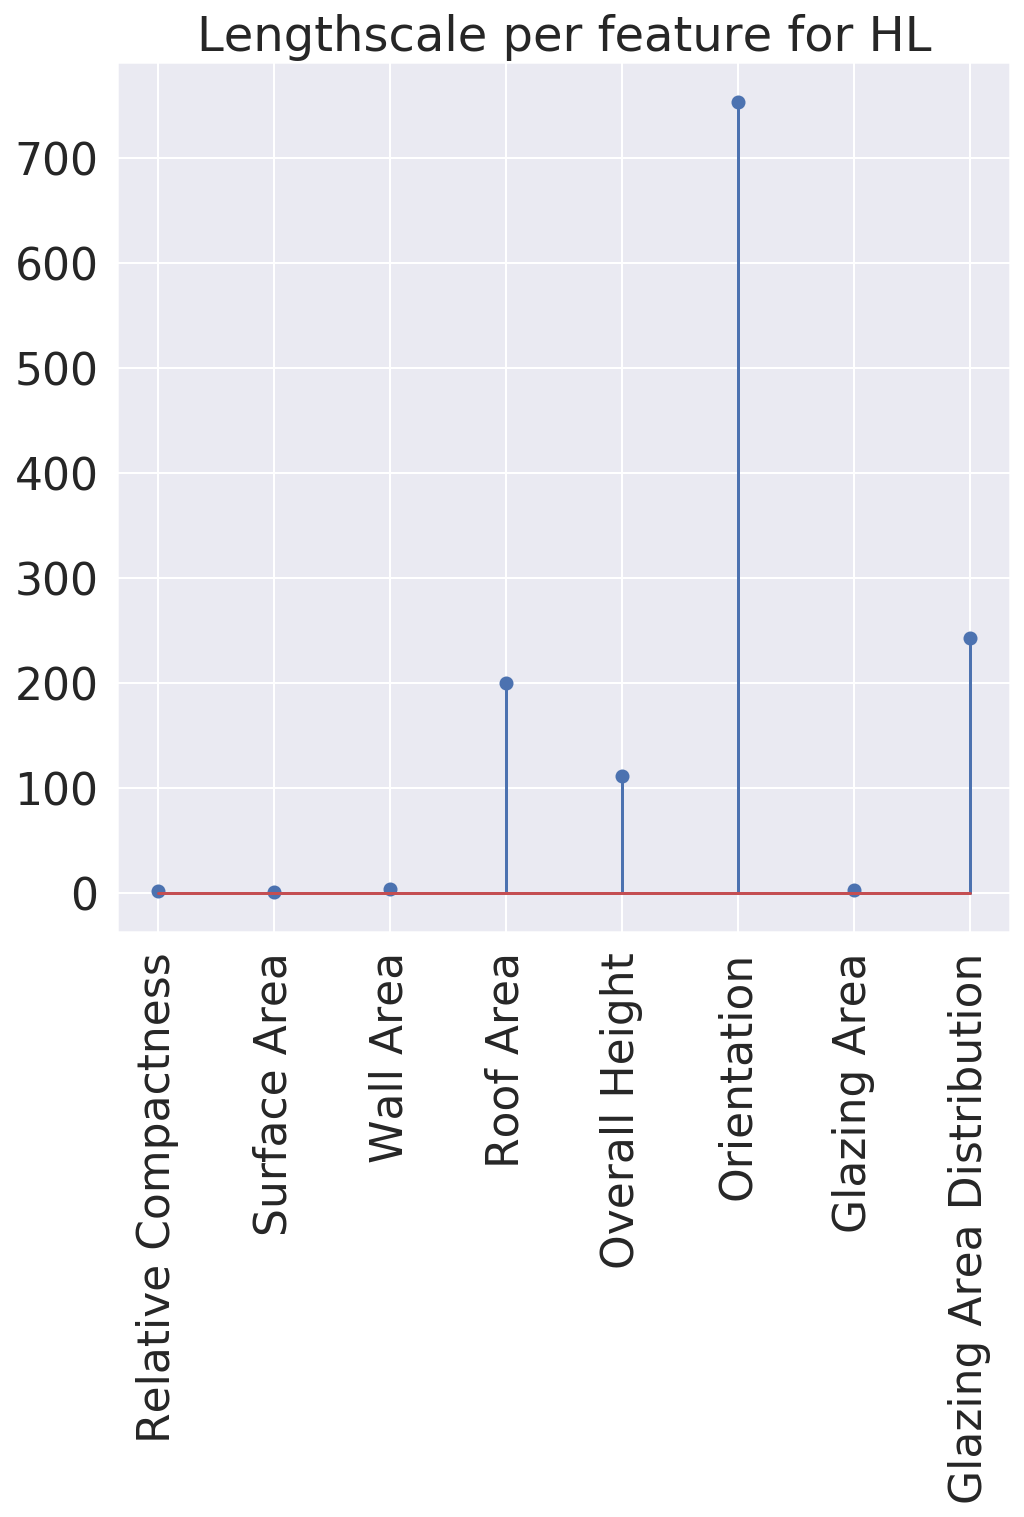

In [0]:
plt.stem(RBF_kernel_hl.rbf.lengthscale.values)
plt.xticks(range(8),names,rotation=90)
plt.title('Lengthscale per feature for HL')

*Accurate quantitative estimation of energy performance of residential buildings using statistical machine learning tools* 

**Table 8**

Measure	| Importance for HL
--- | --- 
Relative Compactness|	50.51 ± 1.15
Surface Area|	50.41 ± 1.41
Wall Area|	40.16 ± 1.09
Roof Area|	20.40 ± 0.95
Overall Height|	8.97 ± 0.68
Orientation|	18.51 ± 0.44
Glazing Area|	93.12 ± 1.50
Glazing Area Distribution|	38.84 ± 0.94


Analyzing the paper results and the obtained ones, we can see that our 4 worse features coincide: **Overall Height, Orientation, Roof Area, Glazing Area Distribution** in inverse order of importance for the paper. In our case, the order is different.

In importance order, the first 4 also coincide with our results but with some variations.

**d) Compute the test MAE & MSE using the GP posterior mean and the optimized hyperparameters**

In [0]:
mean_hl,_ = model_hl.predict(X_test,full_cov=True)

In [0]:
print('MAE: ', mean_absolute_error(Y_test_HL,mean_hl))
print('MSE: ', mean_squared_error(Y_test_HL,mean_hl))

MAE:  0.36322466404444664
MSE:  0.27918459076196034


**Table 5**

label |IRLS|	RF
---|--- | ---
HL MAE|	2.14 ± 0.24|	0.51 ± 0.11

**Table 6**

label |IRLS|	RF
---|--- | ---
HL MSE	|9.87 ± 2.41	|1.03 ± 0.54

Our model clearly outperforms both methods proposed by the paper.

**2) Try to improve your results by using a more complicated kernel, in which you combine various covariance functions.**

### Cooling Load Estimation

**a) Build a GP regression model**

In [0]:
# define kernel
RBF_kernel_cl = GPy.kern.RBF(X_train.shape[1],ARD=True) + GPy.kern.White(X_train.shape[1])

# create simple GP model - HL: Heating Load

model_cl = GPy.models.GPRegression(X_train,Y_train_CL,RBF_kernel_cl)

# optimize and plot
model_cl.optimize(messages=True,max_f_eval = 1000)

In [0]:
print('Parameters:\n', RBF_kernel_cl.parameter_names())

print('\nVariance:\n',RBF_kernel_cl.rbf.variance.values)

print('\nLengthScale:\n',RBF_kernel_cl.rbf.lengthscale.values)

print('\nWhite Variance:\n',RBF_kernel_cl.white.variance.values)

Parameters:
 ['rbf.variance', 'rbf.lengthscale', 'white.variance']

Variance:
 [660.19490378]

LengthScale:
 [  1.79598227  61.99961252   1.06626043 140.5320255  204.02354456
 218.21293151  11.78992413 952.90550621]

White Variance:
 [1.28953374]


**b) Fit the covariance function parameters and noise variance.**

In [0]:
model_cl.optimize_restarts(num_restarts = 10)

 /usr/local/lib/python3.6/dist-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 1227.146910215437
Optimization restart 2/10, f = 1229.8274248486568
Optimization restart 3/10, f = 1229.2948943380234
Optimization restart 4/10, f = 1230.022476261193
Optimization restart 5/10, f = 1230.3463204590187
Optimization restart 6/10, f = 1228.201887531967
Optimization restart 7/10, f = 1230.3198571981443
Optimization restart 8/10, f = 1227.807412492203
Optimization restart 9/10, f = 1229.803958110418
Optimization restart 10/10, f = 1224.96668188313


**c) According to the ARD parameters found, what variables are more important for the regression?**

In [0]:
feat_rank = list(zip(RBF_kernel_cl.rbf.lengthscale.values,names))
feat_rank.sort()
feat_rank

[(0.11011314836032232, 'Orientation'),
 (1.000193344941241, 'Wall Area'),
 (1.1642434568449151, 'Roof Area'),
 (1.3683525596373978, 'Glazing Area Distribution'),
 (16.088078328581183, 'Glazing Area'),
 (48.24551842921709, 'Surface Area'),
 (51.74117518445384, 'Overall Height'),
 (119.9812131117386, 'Relative Compactness')]

 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning:In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


Text(0.5, 1.0, 'Lengthscale per feature for CL')

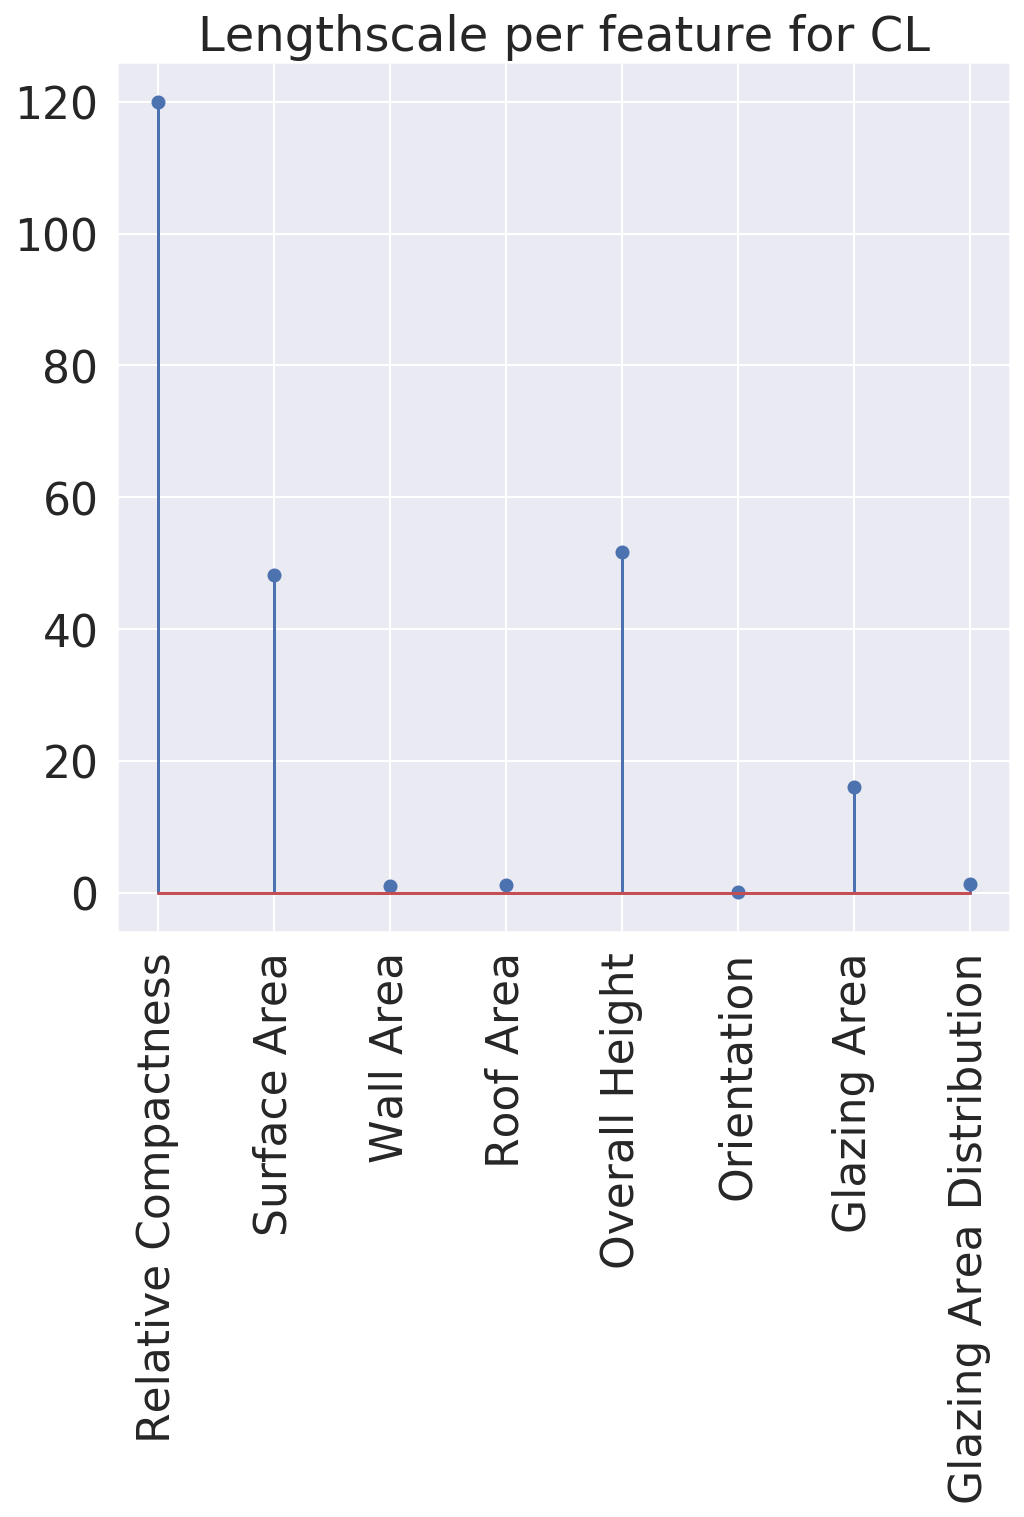

In [0]:
plt.stem(RBF_kernel_cl.rbf.lengthscale.values)
plt.xticks(range(8),names,rotation=90)
plt.title('Lengthscale per feature for CL')

*Accurate quantitative estimation of energy performance of residential buildings using statistical machine learning tools* 

**Table 8**

Measure	| Importance for CL
--- | --- 
Relative Compactness|	43.74 ± 1.11
Surface Area|	43.55 ± 1.08
Wall Area|	32.16 ± 0.83
Roof Area|	20.12 ± 0.87
Overall Height| 9.41 ± 0.72
Orientation|	22.03 ± 0.48
Glazing Area|	86.92 ± 1.58
Glazing Area Distribution|	39.07 ± 0.97

The comparison with the Cooling Load is the same as with the Heating Load.

**d) Compute the test MAE & MSE using the GP posterior mean and the optimized hyperparameters**

In [0]:
mean_cl,_ = model_cl.predict(X_test,full_cov=True)

In [0]:
print('MAE: ', mean_absolute_error(Y_test_CL,mean_cl))
print('MSE: ', mean_squared_error(Y_test_CL,mean_cl))

MAE:  0.5941496798157051
MSE:  0.6807305164658607


**Table 5**

label |IRLS|	RF
---|--- | ---
CL MAE|	**2.21 ± 0.28**|**1.42 ± 0.25**

**Table 6**

label |IRLS|	RF
---|--- | ---
CL	MSE | **11.46 ± 3.63**	|**6.59 ± 1.56**

We can see how our model outperforms the results of the paper.

**2) Try to improve your results by using a more complicated kernel, in which you combine various covariance functions.**

### Sparse GP implementation 

Try to implement an sparse version of the GP regressor, optimized to find a set of **inducing points** that the GP relies on to do the prediction. Measure the test error prediction for 20, 40, and 100 inducing points. 

In [0]:
from sklearn import metrics
ind_points=[20, 40, 100]
 
MSE_ind_HL = []
MAE_ind_HL = []
MSE_ind_CL = []
MAE_ind_CL = []


for number_points in ind_points:

  model_HL = GPy.models.SparseGPRegression(X_train,Y_train_HL,num_inducing=number_points)
  model_HL.likelihood.variance = 0.05

  model_HL.inducing_inputs.fix()
  model_HL.randomize()
  model_HL.Z.unconstrain()
  model_HL.optimize('bfgs')

  hl_mean, hl_var = model_HL.predict(X_test)

  MSE_HL= metrics.mean_squared_error(Y_test_HL, hl_mean)
  MAE_HL= metrics.mean_absolute_error(Y_test_HL, hl_mean)
  MSE_ind_HL.append(MSE_HL)
  MAE_ind_HL.append(MAE_HL)

  #now we do the same for cooling load

  model_CL = GPy.models.SparseGPRegression(X_train, Y_train_CL, num_inducing=number_points)
  model_CL.likelihood.variance = 0.05

  model_CL.inducing_inputs.fix()
  model_CL.randomize()
  model_CL.Z.unconstrain()
  model_CL.optimize('bfgs')

  cl_mean, cl_var = model_CL.predict(X_test)

  MSE_CL= metrics.mean_squared_error(Y_test_CL, cl_mean)
  MAE_CL= metrics.mean_absolute_error(Y_test_CL, cl_mean)
  MSE_ind_CL.append(MSE_CL)
  MAE_ind_CL.append(MAE_CL)

 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning:In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning:In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


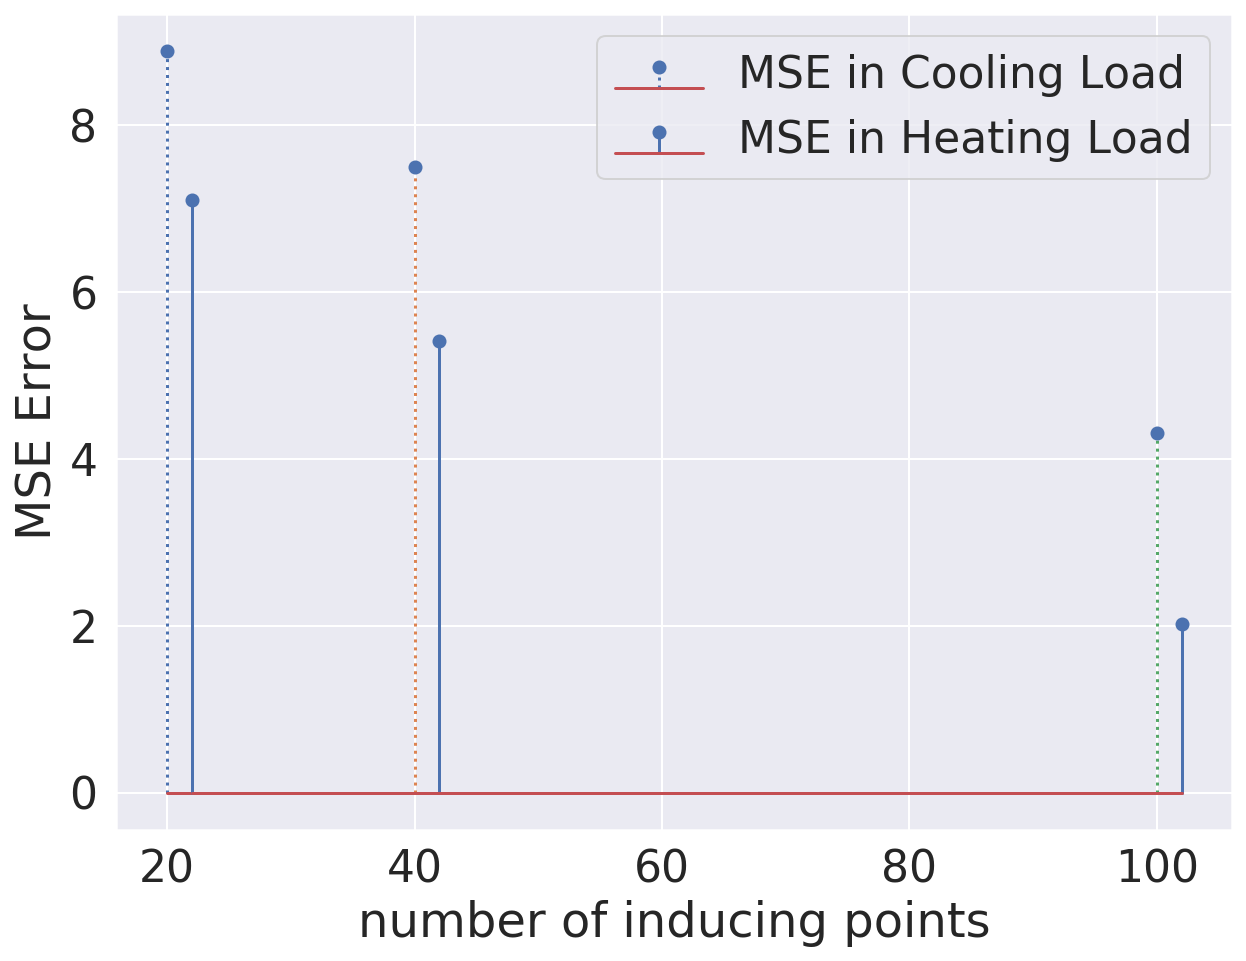

 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning:In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning:In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


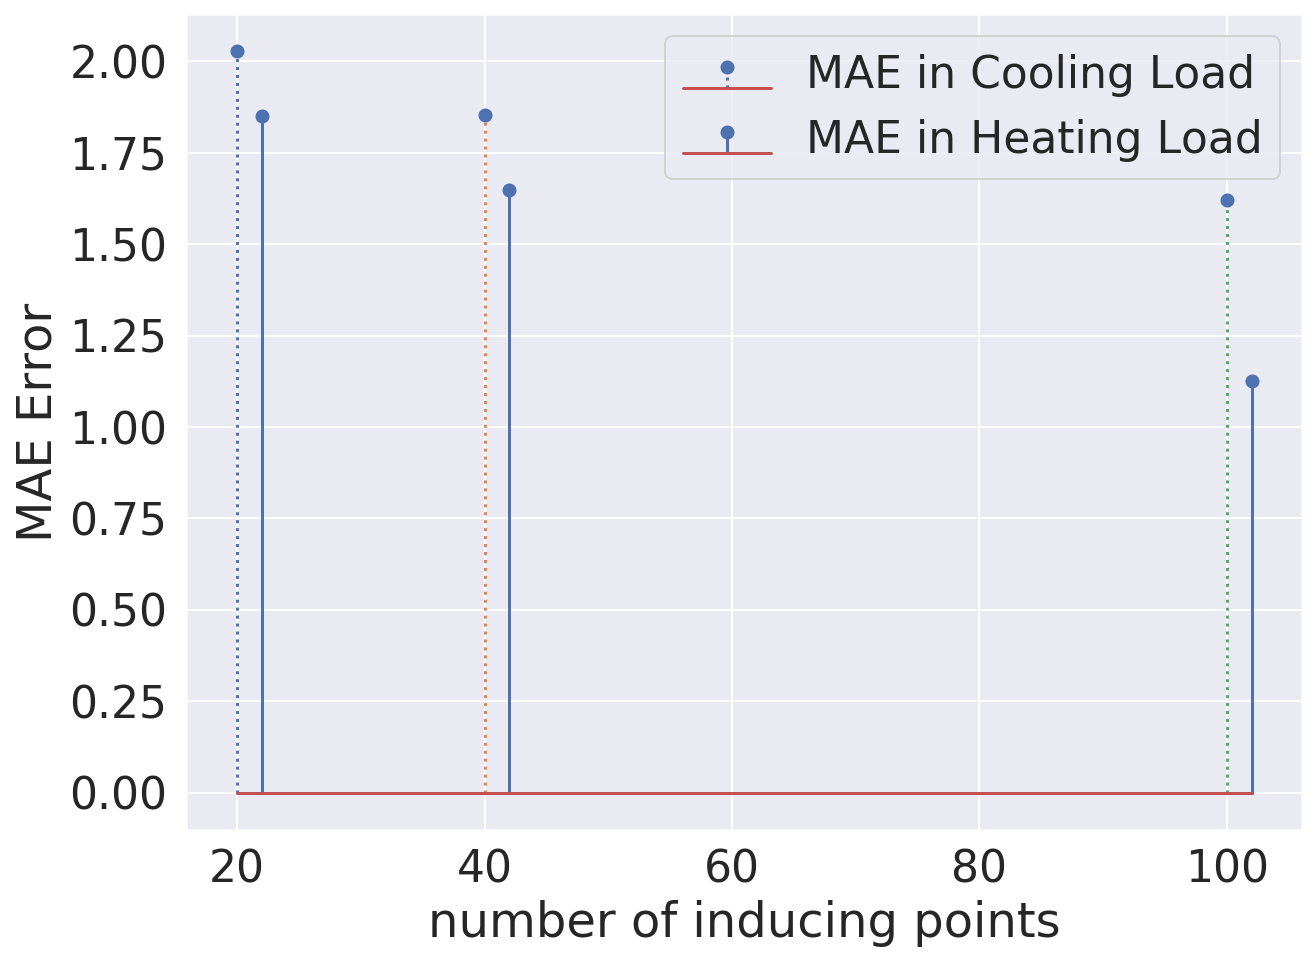

In [0]:
plt.figure(figsize=(10,7.5))
plt.stem(ind_points, MSE_ind_CL, linefmt = ':', label='MSE in Cooling Load')
plt.stem([22, 42, 102], MSE_ind_HL, label='MSE in Heating Load')
plt.ylabel('MSE Error')
plt.xlabel('number of inducing points')
plt.legend()
plt.show()

plt.figure(figsize=(10,7.5))
plt.stem(ind_points, MAE_ind_CL, linefmt = ':', label='MAE in Cooling Load')
plt.stem([22, 42, 102], MAE_ind_HL, label='MAE in Heating Load')
plt.ylabel('MAE Error')
plt.xlabel('number of inducing points')
plt.legend()
plt.show()

As expected, with more inducing points, our model performs better, we can check it in both the graphs and the values printed below.

In [0]:
for i in range(len(ind_points)):
  print('Errors with %0.0f inducing points' %(ind_points[i]))
  print('Heating Load: ')
  print('\tMSE = %f' % (MSE_ind_HL[i]))
  print('\tMAE = %f' % (MAE_ind_HL[i]))
  print('Cooling Load: ')
  print('\tMSE = %f' % (MSE_ind_CL[i]))
  print('\tMAE = %f' % (MAE_ind_CL[i]))
  print('\n')

Errors with 20 inducing points
Heating Load: 
	MSE = 7.105459
	MAE = 1.851252
Cooling Load: 
	MSE = 8.884563
	MAE = 2.027641


Errors with 40 inducing points
Heating Load: 
	MSE = 5.416171
	MAE = 1.649437
Cooling Load: 
	MSE = 7.502322
	MAE = 1.853556


Errors with 100 inducing points
Heating Load: 
	MSE = 2.017121
	MAE = 1.125776
Cooling Load: 
	MSE = 4.305145
	MAE = 1.620776


